## Insights from homeworkout data

During the journey to physical fitness, I have been collecting heart rate and calory burning data for [Barry's Bootcamp](https://www.barrys.com/) high intensity interval training classes. The goal is to better understand:

- How heart rate correlates with calories burn?
- Which workout equipment is more effective, weights, bands, or body weight?
- Does full-body workout burn more calories compared with body part focused workout?

In [1]:
# load packages 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib import pyplot
import matplotlib.image as mpimg
import seaborn as sns
import scipy.stats as stats
from matplotlib.axes._axes import _log as matplotlib_axes_logger

# load data
df = pd.read_excel('data/home_workout.xlsx', sheet_name=0)
print('Total number of workouts: {}'.format(df.shape[0]))
# top 3 and last 2 records
print('First 2 and last 2 workout data:')
pd.concat([df.head(2), df.tail(2)])

Total number of workouts: 185
First 2 and last 2 workout data:


,Date,DayOfWeek,Class,ClassType,Duration,Calories_Active,Calories_Total,Heart_Rate_Avg,Heart_Rate_Min,Heart_Rate_Max,Heart_Rate_Image
0,2020-04-13,Mon,Arms & Abs,Weights,33,148,192,127,102,148,04_13_2020_1.png
1,2020-04-13,Mon,Arms & Abs,Body Weight,33,149,192,129,107,154,04_13_2020_2.png
183,2020-08-08,Sat,Full Body (Upper Focus),Weights,48,229,284,136,99,169,08_08_2020_1.png
184,2020-08-09,Sun,Total Body,Bands,42,217,266,142,104,168,08_09_2020_1.png


### How heart rate correlates with calories burn?

To start with, let's take a look at the range and distribution of active calories burn in the dataset.

In [2]:
# basic statistics of active calories
df['Calories_Active'].describe()

count    185.000000
mean     207.675676
std       38.967834
min      115.000000
25%      179.000000
50%      207.000000
75%      233.000000
max      306.000000
Name: Calories_Active, dtype: float64

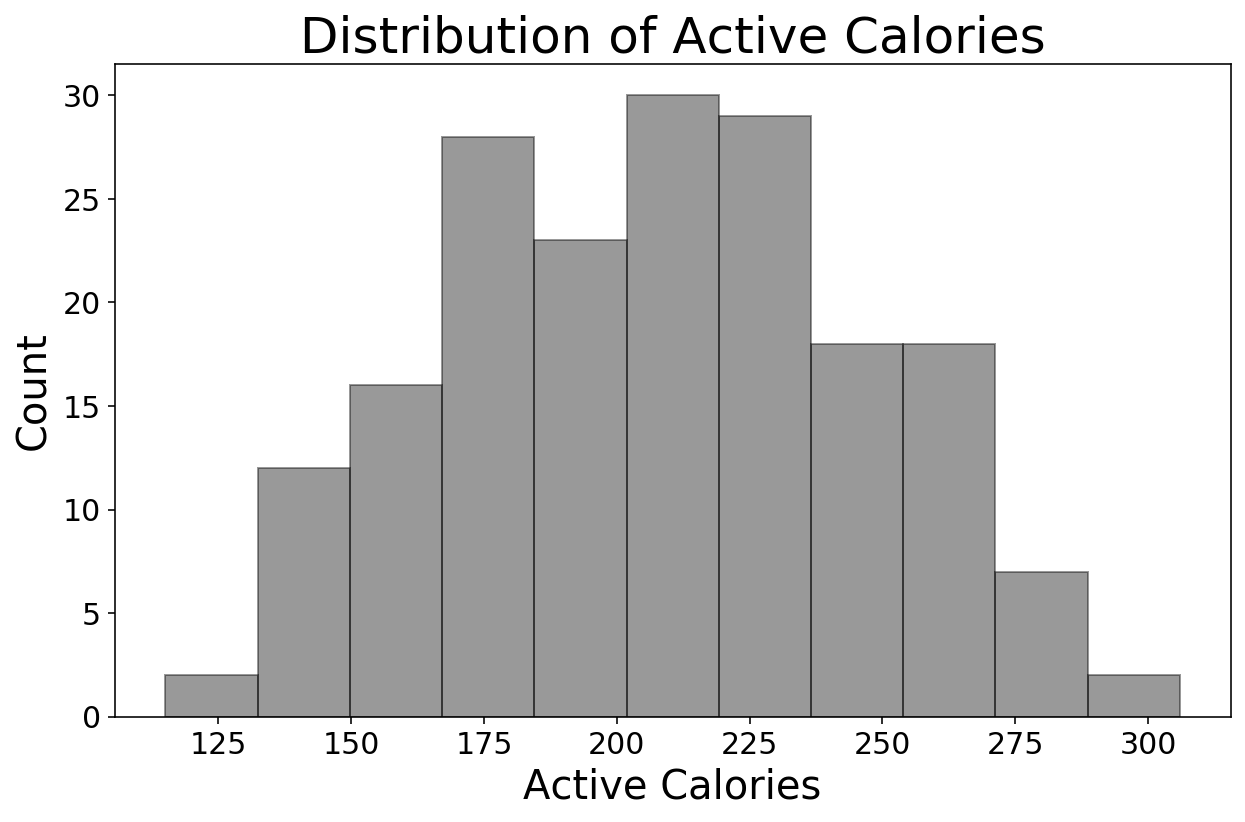

In [3]:
# Histogram
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(df['Calories_Active'], kde=False, color='black', hist_kws=dict(edgecolor="k", linewidth=1));
plt.title('Distribution of Active Calories', fontsize=25)
plt.xlabel('Active Calories', fontsize=20, rotation=0)
plt.ylabel('Count', fontsize=20, rotation=90)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0);

The active calories burned ranges from 115 cal to 306 cal, with an average of 208 cal. It follows Gaussian distribution. When people workout, heart rate ramps up. Let's start with comparing the heart rate profile for the highest and lowest calorie burn workouts.

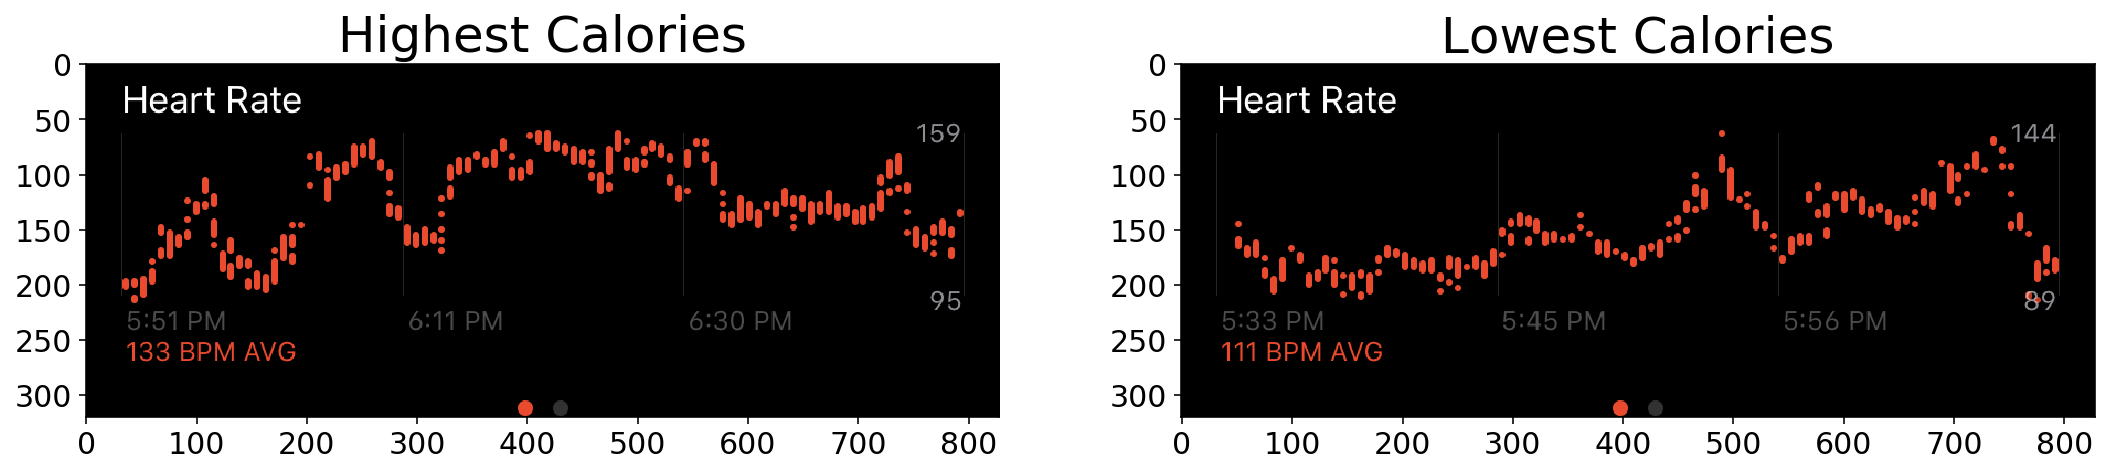

In [4]:
df = df.sort_values(by='Calories_Active', ascending=False)
# highest calorie burn
img_highest = df.iloc[0]['Heart_Rate_Image']
# lowest calorie burn
img_lowest = df.iloc[df.shape[0]-1]['Heart_Rate_Image']
# plot heart rate profile for highest and lowest calories burn workouts
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 9))
# left plot
plt.subplot(1,2,1)
img=mpimg.imread('data/'+img_highest)
plt.title('Highest Calories', fontsize=25)
imgplot = plt.imshow(img[730:1050])
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0)
# right plot
plt.subplot(1,2,2)
img=mpimg.imread('data/'+img_lowest)
plt.title('Lowest Calories', fontsize=25)
imgplot = plt.imshow(img[730:1050])
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0);

There is big difference in heart rate profiles and average heart rates comparing workouts with the highest and lowest calories burn. Also the workout durations are different. In fact, Barry's Bootcamp increased the class duration from 30 minute to 45 minute (without charging extra). Scatter plot of workout duration and avearge heart rate colored by active calories could help us better understand the relationship.

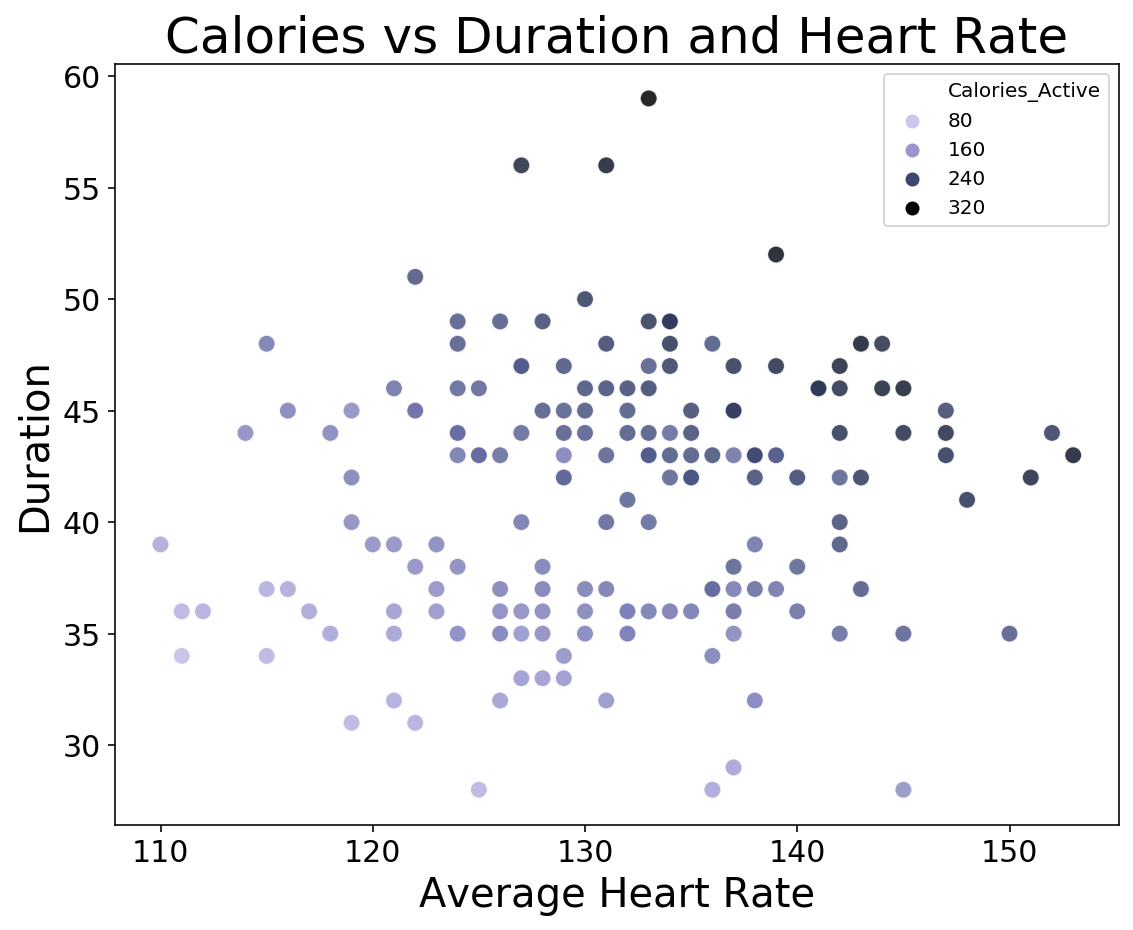

In [5]:
# cross-plot of duration and heart rate colored by active calories
plt.figure(figsize=(9,7))
# cmap = sns.cubehelix_palette(dark=0.0, light=.8, as_cmap=True)
cmap = sns.cubehelix_palette(start=2.8, rot=.1, dark=0.01, light=.8, as_cmap=True)
sns.scatterplot(x="Heart_Rate_Avg", y="Duration", 
                hue="Calories_Active",
                s=75, alpha=0.85, data=df, palette=cmap)
plt.title('Calories vs Duration and Heart Rate', fontsize=25)
plt.xlabel('Average Heart Rate', fontsize=20, rotation=0)
plt.ylabel('Duration', fontsize=20, rotation=90)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0);
plt.legend(loc='upper right')
plt.show()

The plot indicates that the longer the workout or higher the average heart rate, will get a higher calaorie burn. In order to better understand the correlation between heart rate and calorie burn, one needs to reduce the variablility of workout duration. To do so, calorie burn is normalized to 50 min to reduce the variability of workout duration.

In [6]:
# normalize calories to 50 min workout
df['Calories_Active_50min'] = df['Calories_Active'] / df['Duration'] * 50

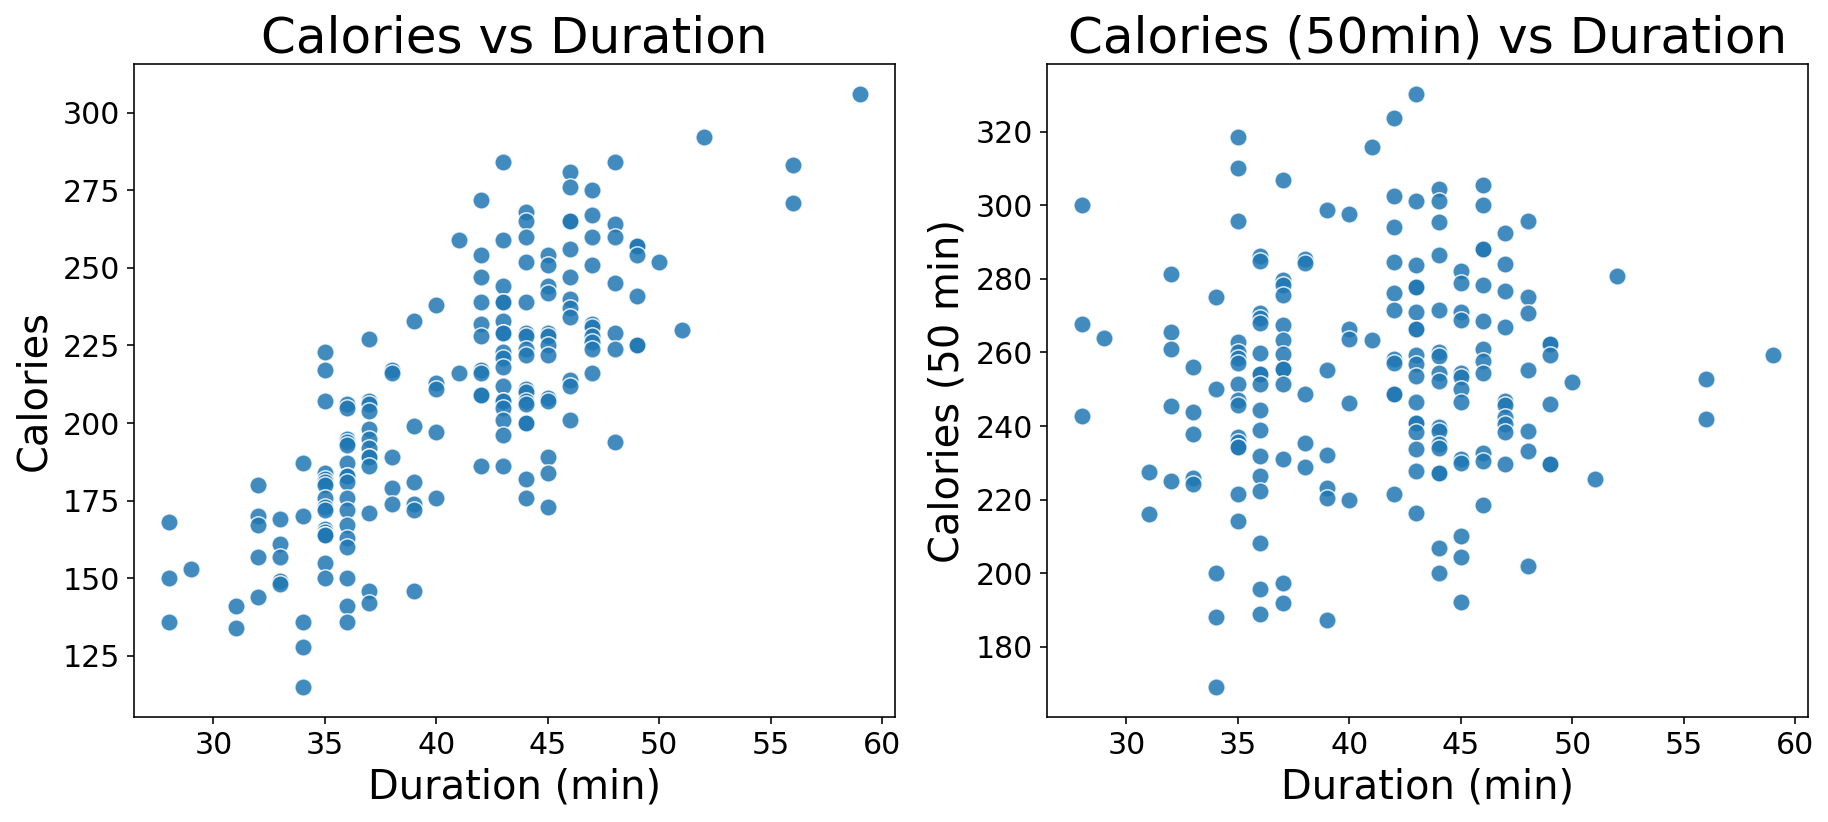

In [7]:
# calories vs duration before vs after normalization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
# left plot
plt.subplot(1,2,1)
sns.scatterplot(x='Duration', y="Calories_Active", 
                s=75, alpha=0.85, data=df)
plt.title('Calories vs Duration', fontsize=25)
plt.xlabel('Duration (min)', fontsize=20, rotation=0)
plt.ylabel('Calories', fontsize=20, rotation=90)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0);
# right plot
plt.subplot(1,2,2)
sns.scatterplot(x='Duration', y="Calories_Active_50min", 
                s=75, alpha=0.85, data=df)
plt.title('Calories (50min) vs Duration', fontsize=25)
plt.xlabel('Duration (min)', fontsize=20, rotation=0)
plt.ylabel('Calories (50 min)', fontsize=20, rotation=90)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0);

In [8]:
# correlation coefficient of calories with duration
cc = scipy.stats.pearsonr(df['Duration'], df['Calories_Active'])[0]
cc_norm = scipy.stats.pearsonr(df['Duration'], df['Calories_Active_50min'])[0]
print('Correlation with workout duration is reduced from %.2f to %.2f.' % (cc, cc_norm))

Correlation with workout duration is reduced from 0.79 to 0.09.


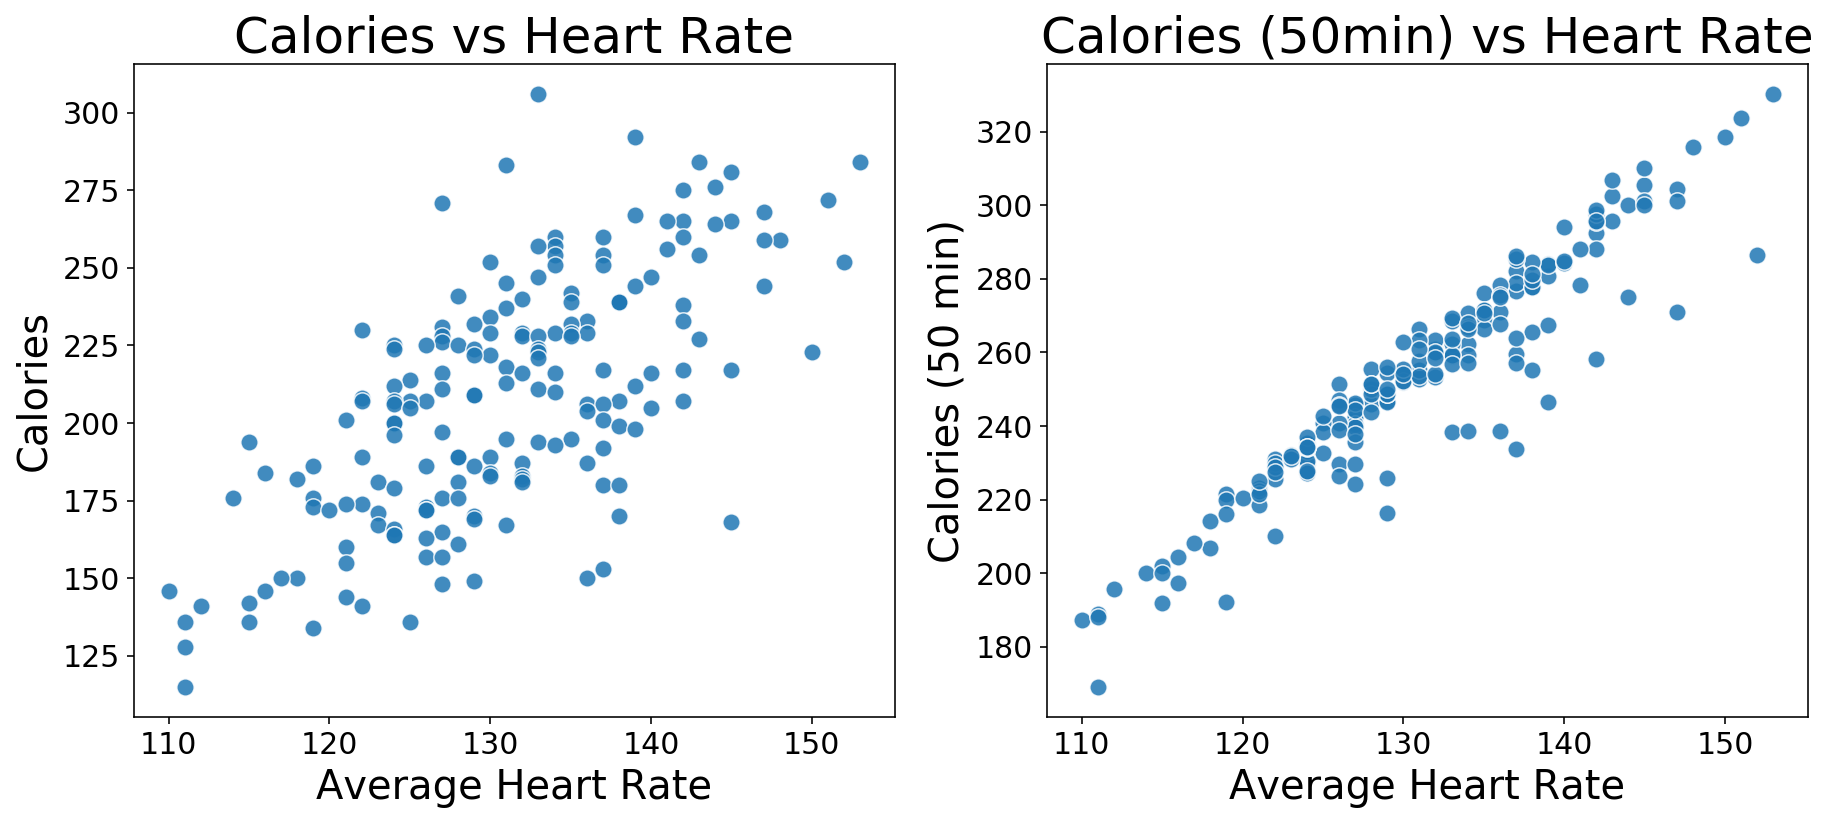

In [9]:
# calories vs average heart rate before vs after normalization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
# left plot
plt.subplot(1,2,1)
sns.scatterplot(x='Heart_Rate_Avg', y="Calories_Active", 
                s=75, alpha=0.85, data=df)
plt.title('Calories vs Heart Rate', fontsize=25)
plt.xlabel('Average Heart Rate', fontsize=20, rotation=0)
plt.ylabel('Calories', fontsize=20, rotation=90)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0);
# right plot
plt.subplot(1,2,2)
sns.scatterplot(x='Heart_Rate_Avg', y="Calories_Active_50min", 
                s=75, alpha=0.85, data=df)
plt.title('Calories (50min) vs Heart Rate', fontsize=25)
plt.xlabel('Average Heart Rate', fontsize=20, rotation=0)
plt.ylabel('Calories (50 min)', fontsize=20, rotation=90)
plt.xticks(fontsize=15, rotation=0)
plt.yticks(fontsize=15, rotation=0);

In [10]:
# correlation coefficient of calories with duration
cc = scipy.stats.pearsonr(df['Heart_Rate_Avg'], df['Calories_Active'])[0]
cc_norm = scipy.stats.pearsonr(df['Heart_Rate_Avg'], df['Calories_Active_50min'])[0]
print('Correlation with average heart rate is increased from %.2f to %.2f.' % (cc, cc_norm))

Correlation with average heart rate is increased from 0.67 to 0.94.


**Conclusion**: Average heart rate is highly positively correlated with calories burn. The higher average heart rate, the higher calories burned.  

### Which workout equipment is more effective, weights, bands, or body weight?

Due to limitation of equipments, home workouts commonly use weights (dumbells), bands, and body weight. Which one is more effective in calorie burn? Let's check on the distribution of normalized calories among the three class types. [Boxplot](https://www.wellbeingatschool.org.nz/information-sheet/understanding-and-interpreting-box-plots) is a helpful visualization for this need.

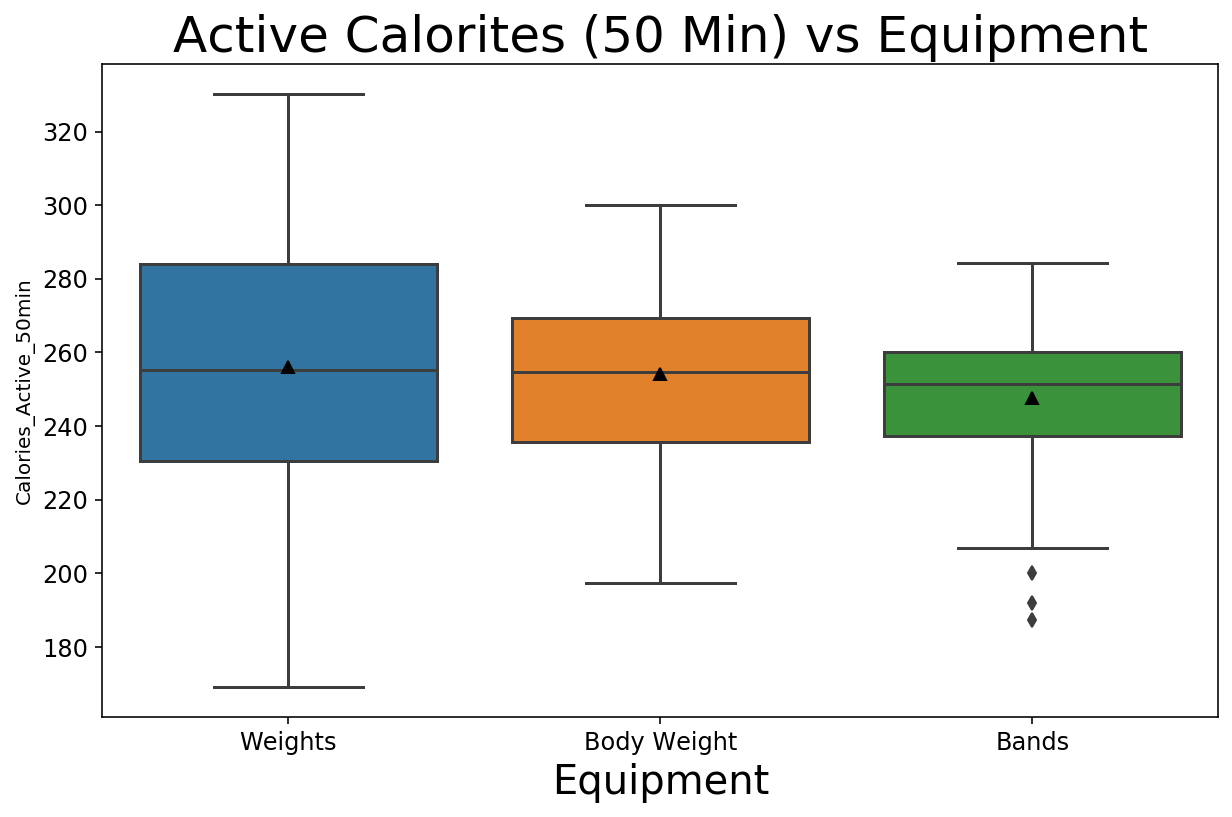

In [11]:
# box plot of calories over 
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="ClassType", 
                 y="Calories_Active_50min", 
                 showmeans=True, 
                 meanprops={"markerfacecolor":"black", "markeredgecolor":"black"},
                 data=df)
plt.title('Active Calorites (50 Min) vs Equipment', fontsize=25)
plt.xlabel('Equipment', fontsize=20, rotation=0)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.show()

Except the wider range of varition of weights class, don't observe difference in averaged calories (black triangle). Let's take a look of the exact averaged calories in each class type.

In [12]:
# average normalized calories in each class type
avg_type = df.groupby('ClassType')['Calories_Active_50min'] \
                .agg({'mean'}).reset_index() \
                .rename(columns={'ClassType': 'class type', 'mean': 'average calories'})
avg_type['average calories'] = avg_type['average calories'].astype(int)
avg_type.sort_values(by='average calories', ascending=False)

,class type,average calories
2,Weights,256
1,Body Weight,254
0,Bands,247


Very similar averaged calories burns among the three class types. Let's perform statistical test to see if the difference in average calaories is significant. As there are multiple sample groups, multi-sample ANOVA is used. If the p_value is bigger than 0.05, then statistically the difference of averaged calories burn is not significant.

In [13]:
p_value = stats.kruskal(df.loc[df['ClassType']=='Weights', 'Calories_Active_50min'], \
              df.loc[df['ClassType']=='Body Weight', 'Calories_Active_50min'], \
              df.loc[df['ClassType']=='Bands', 'Calories_Active_50min'])[1]

if p_value < 0.05:
    conclud = 'statistically significant'
else:
    conclud = 'statistically insignificant'

print('P-value is {:0.7f}'.format(p_value) + ', meaning ' + conclud + '.')

P-value is 0.3034526, meaning statistically insignificant.


**Conclusion**: Weights, bands, and body weight workouts are all effective in calorie burn, no statistical difference observed. 

### Does full-body workout burn more calories compared with body part focused workout?

Barry's Bootcamp offer workouts for different body part focus through the week. Let's take a look at more details on the calories burns for different workout classes.

In [14]:
df_output = df.groupby('Class') \
                .agg({'Date':'size', 'Calories_Active_50min': 'mean'}) \
                .reset_index() \
                .rename(columns={'Date': 'count', 'Calories_Active_50min': 'average calories (50 min)'}) \
                .sort_values('average calories (50 min)', ascending=False)
df_output['average calories (50 min)'] = df_output['average calories (50 min)'].astype(int)
df_output

,Class,count,average calories (50 min)
3,Full Body (Lower Focus),24,268
5,Total Body,52,265
4,Full Body (Upper Focus),29,256
0,Abs & Ass,24,248
1,Arms & Abs,29,239
2,"Chest, Back & Abs",27,232


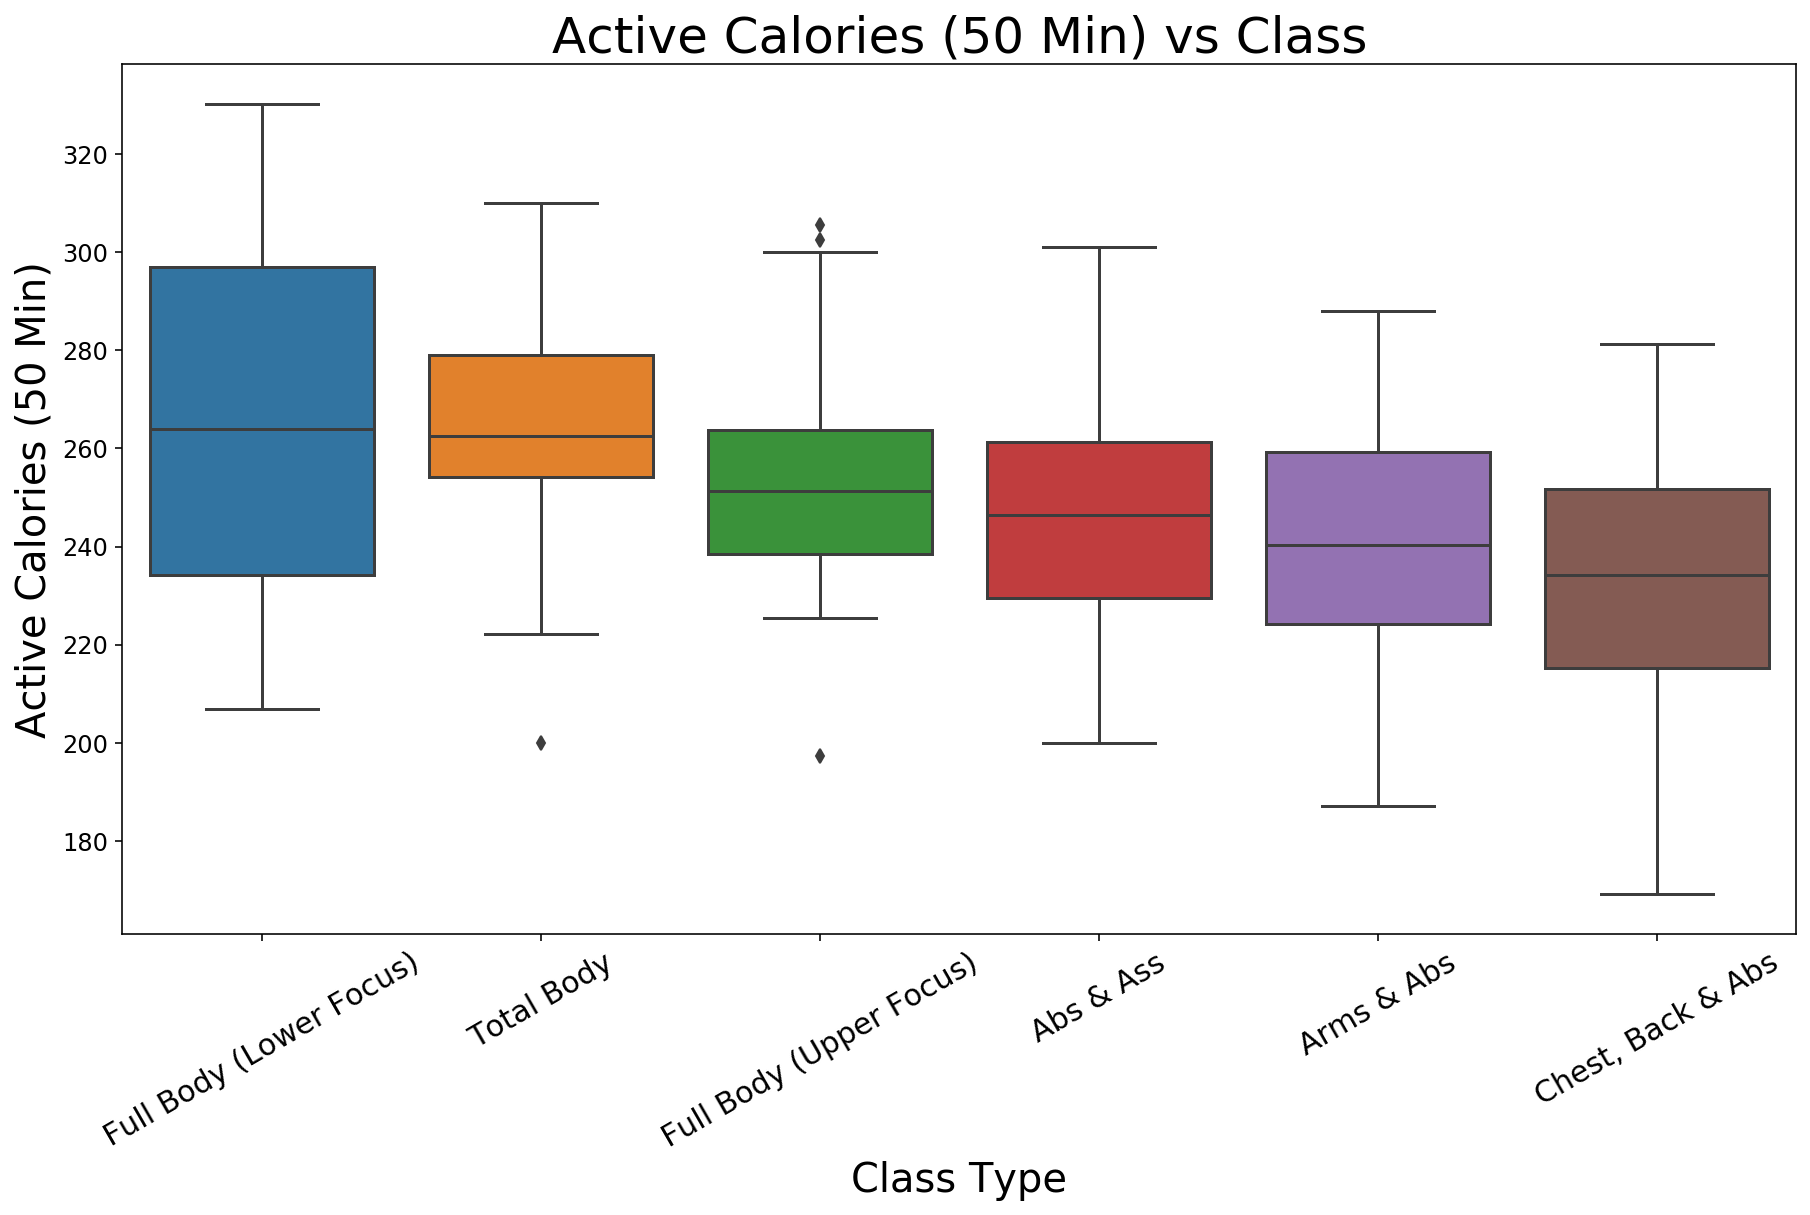

In [15]:
plt.figure(figsize=(15,8))
ax = sns.boxplot(x="Class", 
                 y="Calories_Active_50min", 
                 order=list(df_output['Class']),
                 data=df)
plt.title('Active Calories (50 Min) vs Class', fontsize=25)
plt.xlabel('Class Type', fontsize=20, rotation=0)
plt.ylabel('Active Calories (50 Min)', fontsize=20, rotation=90)
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=12, rotation=0)
plt.show()

The data indicates that full body workouts have a higher calorie burns compared with body part focused workouts, such as arms, chest and backs. We can further group the classes to two categories, full body and body part based on their focus, and perform bar chart visualization and statistical test.

In [16]:
# total body vs regional focused
df['Focus'] = 'body-part'
df.loc[df['Class'].str.find('Body')!=-1, 'Focus'] = 'full-body'

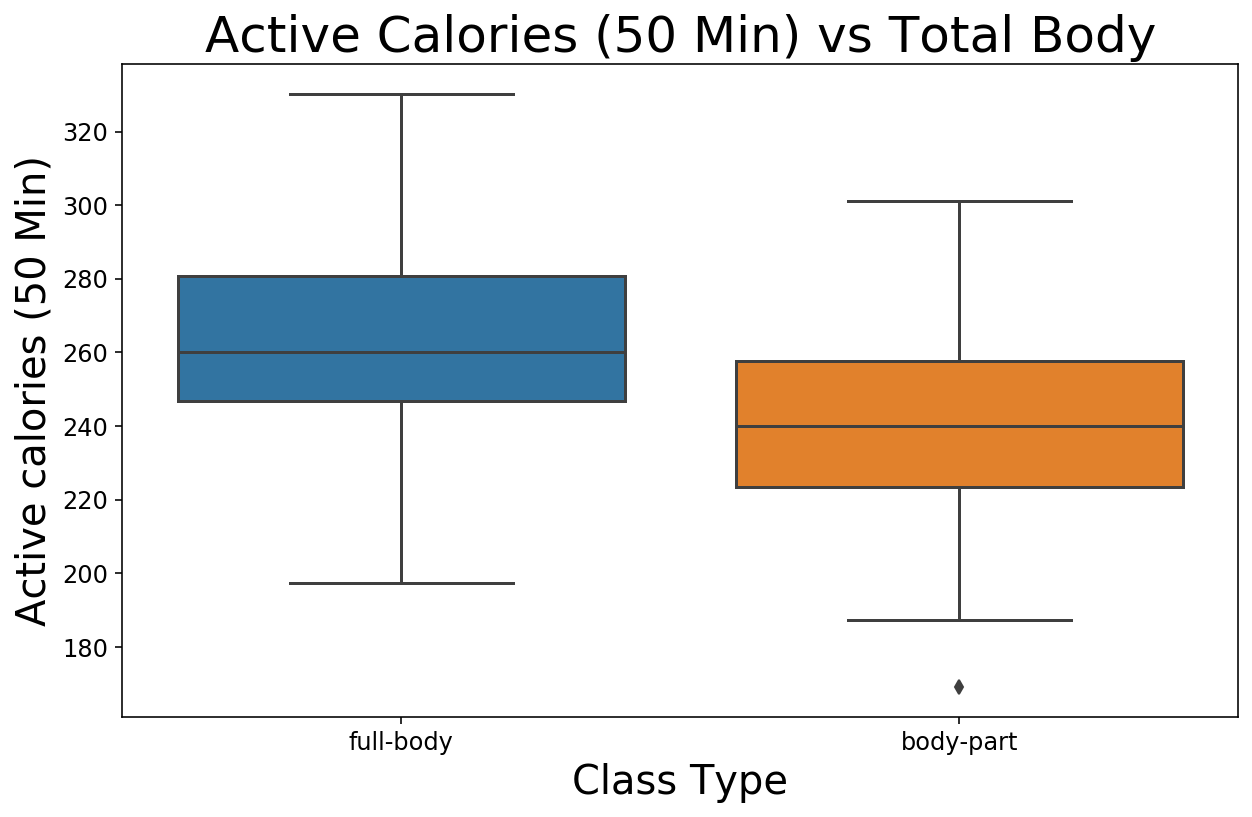

In [17]:
# bar chart of calories comparing workout focus
plt.figure(figsize=(10,6))
ax = sns.boxplot(x="Focus", 
                 y="Calories_Active_50min", 
                 order = ['full-body', 'body-part'],
                 data=df)
plt.title('Active Calories (50 Min) vs Total Body', fontsize=25)
plt.xlabel('Class Type', fontsize=20, rotation=0)
plt.ylabel('Active calories (50 Min)', fontsize=20, rotation=90)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.show()

Let's perform statistical test to see if the difference in average calaories is significant. U-test is used here as the sample distribution may not be Guassian. If the p_value is smaller than 0.05, then statistically the difference of averaged calories burn is significant.

In [18]:
# U-test
_, p_value = stats.mannwhitneyu(
                x = df.loc[df['Focus'] == 'full-body', 'Calories_Active_50min'],
                y = df.loc[df['Focus'] != 'full-body', 'Calories_Active_50min'],
                use_continuity = False,
                alternative = 'two-sided')
if p_value < 0.05:
    conclud = 'statistically significant'
else:
    conclud = 'statistically insignificant'

print('P-value is {:0.7f}'.format(p_value) + ', meaning ' + conclud + '.')

P-value is 0.0000001, meaning statistically significant.


**Conclusion**: Full body focused workouts burn more calories compared with body part focused workouts. 